In [1]:
import pandas as pd
from sklearn.metrics import PrecisionRecallDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np

In [2]:
def get_fisher_stat(row, total_genes=68_258_704, defensive_genes=244_022):
    random_prob = 1 - (1-defensive_genes/total_genes)**20
    random_defense_total = random_prob*total_genes
    fisher = stats.fisher_exact([[row['defense_total'], random_defense_total], 
                                [row['total'], total_genes]], alternative='greater')
    return fisher[0], fisher[1]

In [3]:
cluster_defense_count_df = pd.read_csv('../data/interim/cluster_defense_neighbor_test_scores.csv')
test_annotations = pd.read_parquet('../data/interim/test_seq_names_processes.pq')
test_y = pd.read_csv('../data/interim/test_y.csv')

In [5]:
cluster_defense_count_df['fisher_p'] = Parallel(n_jobs=48)(delayed(get_fisher_stat)(row) for _, row in 
                                                         tqdm(cluster_defense_count_df.iterrows(), 
                                                              total=len(cluster_defense_count_df), 
                                                              position=0))

100%|██████████| 176371/176371 [01:22<00:00, 2136.81it/s]


In [6]:
cluster_defense_count_df[['fisher_stat', 'fisher_p']] = pd.DataFrame(cluster_defense_count_df['fisher_p'].to_list(), 
                                                                     index=cluster_defense_count_df.index)

In [7]:
cluster_defense_count_df['defense_frac_n_log_p'] = -np.log10(cluster_defense_count_df['fisher_p'])

In [8]:
test_predictions = (test_y.merge(cluster_defense_count_df[['seq_id', 'fisher_stat', 'fisher_p', 'defense_frac_n_log_p', 
                                                           'defense_total', 'total', 'defense_percent']], 
                                 how='inner', on='seq_id')
                    .sample(frac=1, random_state=7))

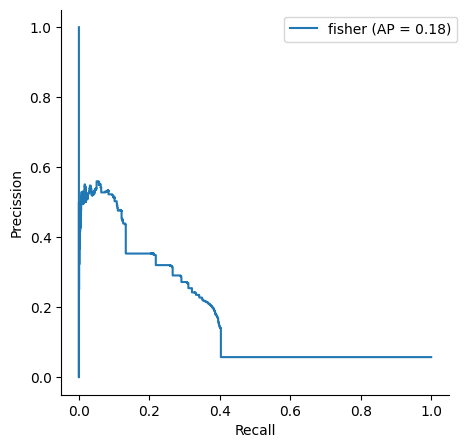

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
display = PrecisionRecallDisplay.from_predictions(test_predictions['defense'], 
                                                  test_predictions['defense_frac_n_log_p'], 
                                                  name='fisher', 
                                                  ax=ax)
sns.despine()
plt.xlabel('Recall')
plt.ylabel('Precission')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper right")

In [10]:
test_prediction_annotations = test_predictions.merge(test_annotations, 
                                                     how='inner', on='seq_id')

In [11]:
test_prediction_annotations

,seq_id,defense,fisher_stat,fisher_p,defense_frac_n_log_p,defense_total,total,defense_percent,protein_id,protein_context_id,gene_name,name,go_process,cog_name
0,55ae76da9e96a6f206771a26ee6018e39319e97015b71a...,False,0.000000,1.000000,-0.000000,0,2,0.000000,WP_054359830.1,WP_054359830.1|NZ_LJYW01000001.1|3827855|-,None,uroporphyrinogen-III synthase,tetrapyrrole biosynthetic process,None
1,bb02e8ccf614c1389fbe6a655e87b713e24b3daca232cf...,False,0.000000,1.000000,-0.000000,0,2,0.000000,WP_111978500.1,WP_111978500.1|NZ_QMED01000012.1|34881|-,None,Na+/H+ antiporter NhaC,sodium ion transport | proton transmembrane tr...,None
2,0e34480a8c9e9fe46f2c2f8ba87c0d17abd8cc0c761b5e...,False,0.000000,1.000000,-0.000000,0,1,0.000000,WP_083461523.1,WP_083461523.1|NZ_BBCG01000079.1|5103|-,None,MerR family transcriptional regulator,regulation of transcription%2C DNA-templated,None
3,704e54e553ee3de4f04b9cca6c82e6712555b575669bfc...,False,0.000000,1.000000,-0.000000,0,2,0.000000,WP_245196786.1,WP_245196786.1|NZ_JAATJE010000002.1|73154|-,None,"succinate dehydrogenase, cytochrome b556 subunit",tricarboxylic acid cycle,None
4,7df1af6c61fdad475cc3dc9a8567dd848579eaab18b2f2...,False,0.000000,1.000000,-0.000000,0,1,0.000000,WP_080522376.1,WP_080522376.1|NZ_LPUF01000001.1|1787908|-,None,NAD-binding protein,potassium ion transport,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176379,31789a94fca2af816476ecd05a264cb0adbf99300ec064...,False,0.000000,1.000000,-0.000000,0,2,0.000000,WP_160367198.1,WP_160367198.1|NZ_WSQA01000001.1|203597|+,None,SusC/RagA family TonB-linked outer membrane pr...,organic substance transport,None
176380,25514d9bd9658aea7130cebdea0cd3d4fcdc0adcc34ef7...,False,0.964476,0.656788,0.182575,1,15,0.066667,WP_131528505.1,WP_131528505.1|NZ_SJSO01000004.1|353071|+,None,mannonate dehydratase,glucuronate catabolic process,None
176381,066890646a078227dbf2d522af733ff0e85213e8fa8ee8...,False,0.000000,1.000000,-0.000000,0,1,0.000000,WP_246456592.1,WP_246456592.1|NZ_JACHVB010000063.1|91229|+,None,PilT/PilU family type 4a pilus ATPase,type IV pilus-dependent motility,None
176382,d9dd191a48b07b412d7a2f89ab997395a2656a37cf2059...,False,0.000000,1.000000,-0.000000,0,23,0.000000,WP_218159592.1,WP_218159592.1|NZ_FOFV01000003.1|289801|-,None,glycoside hydrolase family 9 protein,carbohydrate metabolic process,None


In [12]:
test_prediction_annotations.sort_values('defense_frac_n_log_p', ascending=False).head(50)

,seq_id,defense,fisher_stat,fisher_p,defense_frac_n_log_p,defense_total,total,defense_percent,protein_id,protein_context_id,gene_name,name,go_process,cog_name
12318,2b68f4c22bd617f31e4021c794f1fd89a55f161263d44e...,False,2.987901,2.502976e-225,224.601543,1322,6401,0.206530,WP_085837881.1,WP_085837881.1|NZ_FWFS01000012.1|136726|+,None,site-specific integrase,DNA recombination | DNA integration,None
147272,5ad1f92e4ab6cea6873ea60a9f0063826c3d72c084b5e4...,False,2.987901,2.502976e-225,224.601543,1322,6401,0.206530,WP_001062342.1,WP_001062342.1|NZ_NIYS01000132.1|25420|+,None,integrase domain-containing protein,DNA integration,None
55360,9a5a30e6203d6f5476c5c141c63ab7f8585a82eb6f85c3...,False,2.987901,2.502976e-225,224.601543,1322,6401,0.206530,WP_115213911.1,WP_115213911.1|NZ_QKWJ01000035.1|45352|-,None,tyrosine-type recombinase/integrase,DNA integration,None
27196,dae1b9c304c9a54a9b05d475a1184c210c9af6b0aac912...,False,2.987901,2.502976e-225,224.601543,1322,6401,0.206530,WP_126472704.1,WP_126472704.1|NZ_RXOE01000007.1|294630|+,None,tyrosine-type recombinase/integrase,DNA integration,None
60342,47f5888557e45f580b226cb619a7da41ee653300e10ae6...,False,2.987901,2.502976e-225,224.601543,1322,6401,0.206530,WP_025295410.1,WP_025295410.1|NZ_CP006644.1|6024800|+,None,tyrosine-type recombinase/integrase,DNA integration,None
51674,b1ba5cb3b4e4721074e0a068417135354dbcd57048cccc...,True,4.107952,4.425694e-37,36.354019,138,486,0.283951,WP_127144666.1,WP_127144666.1|NZ_RZMX01000046.1|5194|-,DarTG__DarG,macro domain-containing protein,None,None
22011,99bd705922fa40813a07252dfcaa613bb410629aedaccd...,True,4.107952,4.425694e-37,36.354019,138,486,0.283951,WP_119701214.1,WP_119701214.1|NZ_QJSA01000006.1|121872|-,DarTG__DarG,macro domain-containing protein,None,None
135041,19b38decc7dd99c3b5cbafa5f54de6b2bc3c9e14788954...,True,4.107952,4.425694e-37,36.354019,138,486,0.283951,WP_091554924.1,WP_091554924.1|NZ_FNPH01000003.1|172185|+,DarTG__DarG,macro domain-containing protein,None,None
15278,adfab6c8043378aae86e088c310cf4f78531fe201ba2aa...,True,4.107952,4.425694e-37,36.354019,138,486,0.283951,WP_272857891.1,WP_272857891.1|NZ_CP067134.1|2473167|+,DarTG__DarG,macro domain-containing protein,None,None
40553,fb25380c077d0e4ec4c4dd526bd444654c22c2beae6e1e...,True,4.107952,4.425694e-37,36.354019,138,486,0.283951,WP_044181146.1,WP_044181146.1|NZ_CABKSF010000003.1|135300|-,DarTG__DarG,macro domain-containing protein,None,None


In [13]:
(test_prediction_annotations[~test_prediction_annotations['defense']].groupby('name')
 .agg(n = ('name', 'count'),
      avg_score = ('defense_frac_n_log_p', 'mean'))
 .sort_values('avg_score', ascending=False)
 .head(50))

,n,avg_score
name,,
integrase domain-containing protein,1,224.601543
ABC transporter substrate-binding protein,1,19.892989
translesion error-prone DNA polymerase V subunit UmuC,7,17.341985
replication initiator protein A,9,7.820323
conjugative relaxase,23,5.864380
TIGR03745 family integrating conjugative element membrane protein,11,4.993205
DNA mismatch endonuclease Vsr,27,4.807407
chromosome partition protein MukE,5,2.530220
asparagine synthase C-terminal domain-containing protein,1,2.423002


In [14]:
false_negatives = (test_prediction_annotations[test_prediction_annotations['defense'] & 
                                               (test_prediction_annotations['defense_percent'] == 0)]
                   .sample(n=50, random_state=7))

In [15]:
false_negatives

,seq_id,defense,fisher_stat,fisher_p,defense_frac_n_log_p,defense_total,total,defense_percent,protein_id,protein_context_id,gene_name,name,go_process,cog_name
78730,79025834704598e5e79f89cbf500b17d49161e7365d12e...,True,0.0,1.0,-0.0,0,2,0.0,WP_134566247.1,WP_134566247.1|NZ_SOFP01000032.1|39421|-,Wadjet__JetB_II,TIGR02678 family protein,None,None
23726,0baee85fe142bb3a431a08d503a04d8b2f16abcfff785a...,True,0.0,1.0,-0.0,0,1,0.0,WP_236819069.1,WP_236819069.1|NZ_JAJFNK010000053.1|12452|+,Wadjet__JetA_III,hypothetical protein,None,None
72462,1e47e5e2ae3a41e40ba66313decf6c421dc8a65da683f5...,True,0.0,1.0,-0.0,0,1,0.0,WP_153345178.1,WP_153345178.1|NZ_WIVE01000047.1|19924|+,Cas__cmr3gr5_III-B_III-C_8,hypothetical protein,None,None
75641,0365ae62f0ec6561f71da1da7358c3003a4146085b36eb...,True,0.0,1.0,-0.0,0,1,0.0,WP_138323637.1,WP_138323637.1|NZ_CP040463.1|1329730|-,Cas__cmr6gr7_III-C_1,RAMP superfamily CRISPR-associated protein,None,None
19811,bc1e702cd330ab2eb343dd015ccabd6950b6eb612ab1aa...,True,0.0,1.0,-0.0,0,1,0.0,WP_274941053.1,WP_274941053.1|NZ_CP048829.1|542310|-,DRT_2__drt2,reverse transcriptase domain-containing protein,None,None
17752,14cef5b9b8239255d4a789d0279a8f9b8b52cc38cd9d7e...,True,0.0,1.0,-0.0,0,2,0.0,WP_193993490.1,WP_193993490.1|NZ_JADEXP010000101.1|8612|+,Cas__csm3gr7_III-A_III-D_2,CRISPR-associated RAMP protein Csx7,maintenance of CRISPR repeat elements,None
73761,337527ca184e50da3863cafa7a272e597c47d326d15b68...,True,0.0,1.0,-0.0,0,1,0.0,WP_073156425.1,WP_073156425.1|NZ_FQVL01000011.1|85811|+,Cas__cmr1gr7_III-B_1,type III-B CRISPR module RAMP protein Cmr1,maintenance of CRISPR repeat elements,None
55600,7789b1fe03dc22be90db390b80ee25a4cda13fb0cd379b...,True,0.0,1.0,-0.0,0,5,0.0,WP_257924950.1,WP_257924950.1|NZ_JAMXQV010000024.1|158248|+,Cas__cmr1gr7_III-B_1,type III-B CRISPR module RAMP protein Cmr1,maintenance of CRISPR repeat elements,None
172697,19216688ed02957c780bdc94c3e8866f30fb0ceaa31727...,True,0.0,1.0,-0.0,0,2,0.0,WP_168523485.1,WP_168523485.1|NZ_JAAXLS010000076.1|12133|+,Wadjet__JetA_III,hypothetical protein,None,None
152840,e4b5e1f4ba6843b5a791719b2858a6c0afea1db5e49fad...,True,0.0,1.0,-0.0,0,2,0.0,WP_075618313.1,WP_075618313.1|NZ_MPTA01000002.1|81197|-,Wadjet__JetB_III,DUF6063 family protein,None,None


In [17]:
test_predictions[['seq_id', 'defense_frac_n_log_p']].to_csv('../data/interim/test_predictions_cluster_defense_neighbor.csv', index=False)